# Graph Neural Networks

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import subprocess
import torch
os.environ['TORCH'] = torch.__version__
cuda_version = torch.version.cuda
os.environ['CUDA'] = cuda_version.replace('.','')
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")

!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch_geometric
!pip install pyvis

import torch_geometric

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import networkx as nx
from tqdm.notebook import tqdm

In [35]:
# ---- allowlist common PyG pickled classes (PyTorch 2.6 safe loading) ----
from torch.serialization import add_safe_globals
# Core PyG data classes
from torch_geometric.data import Data
from torch_geometric.data.data import DataTensorAttr, DataEdgeAttr
# Some installs also use these:
try:
    from torch_geometric.data.data import DataGraphAttr, DataGlobalAttr
except Exception:
    DataGraphAttr = DataGlobalAttr = None

# Storages sometimes appear in pickles too:
try:
    from torch_geometric.data.storage import BaseStorage, NodeStorage, EdgeStorage, GlobalStorage
except Exception:
    BaseStorage = NodeStorage = EdgeStorage = GlobalStorage = None

allow = [Data, DataTensorAttr, DataEdgeAttr, DataGraphAttr, DataGlobalAttr,
         BaseStorage, NodeStorage, EdgeStorage, GlobalStorage]
allow = [cls for cls in allow if cls is not None]
add_safe_globals(allow)

In [36]:
def wget_data(url: str, local_path='./tmp_data'):
  os.makedirs(local_path, exist_ok=True)

  p = subprocess.Popen(["wget", "-nc", "-P", local_path, url], stderr=subprocess.PIPE, encoding='UTF-8')
  rc = None

  while rc is None:
    line = p.stderr.readline().strip('\n')
    if len(line) > 0:
      print(line)
    rc = p.poll()

# <span style="color:Orange">Introduction to Graph Data</span>

Graphs can be seen as a system or language for modeling systems that are complex and linked together.
A graph is a data type that is modelled as a set of objects which can be represented as a node or vertex and their relationships which is called edges. A graph data can also be seen as a network data where there are points connected together.

A <span style="color:Violet">node</span> (vertex) of a graph is point in a graph while an <span style="color:Violet">edge</span> is a component that joins edges together in a graph. Graphs can be used to represent data from a lot of domains like biology, physics, social science, chemistry and others.

<div>
<img src="https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/img/GraphNeuralNetworks-GraphExample.jpeg" width=800></img>
</div>

# <span style="color:Orange">Graph Classification</span>

Graphs can be classified into different categories <span style="color:Violet">directed/undirected graphs</span>, <span style="color:Violet">weighted/binary graphs</span> and <span style="color:Violet">homogenous/heterogenous graphs</span>.

- <span style="color:Violet">Directed/Undirected graphs</span>: Directed graphs are the ones that all the edges have directtions while in undirected graphs, the edges are does not have directions

- <span style="color:Violet">Weighted/Binary graphs</span>: Weighted graphs is a type of graph that each of the edges are assigned with a value while binary graphs are the ones that the edges does not have an assigned value.

- <span style="color:Violet">Homogenous/Heterogenous graphs</span>: Homogenous graphs are the ones that all the nodes and/or edges are of the same type (e.g. friendship graph) while heterogenous graphs are graphs where the nodes and/or edges are of different types (e.g. knowledge graph).

Traditional graph analysis methods requires using searching algorithms, clustering spanning tree algorithms and so on. A major downside to using these methods for analysis of graph data is that you require a prior knowledge of the graph to be able to apply these algorithms.

Based on the structure of the graph data, traditional machine learning system will not be able to properly interprete the graph data and thus the advent of the <span style="color:Violet">Graph Neural Network</span> (GNN). Graph neural network is a domain of deep learning that is mostly concerned with deep learning operations on graph datasets.

# <span style="color:Orange">Exploring graph data with Pytorch Geometric</span>

Now we will explore graph and graph neural networks using the PyTorch Geometric (PyG) package (already loaded)

Let's create a function that will help us visualize a graph data.

In [37]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

PyG provides access to a couple of graph datasets. For this notebook, we are going to use [Zachary's karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) network [dataset](https://karateclub.readthedocs.io/en/latest/modules/dataset.html).

Zachary's karate club is a great example of social relationships within a small group. This set of data indicated the interactions of club members outside of the club. This dataset also documented the conflict between the instructor, Mr.Hi, and the club president, John because of course price. In the end, half of the members formed a new club around Mr.Hi, and the other half either stayed at the old karate club or gave up karate.

In [38]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

Now that we have imported a graph dataset, let's look at some of the properties of a graph dataset. We will look at some of the properties at the level of the dataset and then select a graph in the dataset to explore it's properties.

In [39]:
print('Dataset properties')
print('==============================================================')
print(f'Dataset: {dataset}') #This prints the name of the dataset
print(f'Number of graphs in the dataset: {len(dataset)}')
print(f'Number of features: {dataset.num_features}') #Number of features each node in the dataset has
print(f'Number of classes: {dataset.num_classes}') #Number of classes that a node can be classified into

# Since we have one graph in the dataset, we will select the graph and explore it's properties
data = dataset[0]
print('Graph properties')
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}') #Number of nodes in the graph
print(f'Number of edges: {data.num_edges}') #Number of edges in the graph
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}') # Average number of nodes in the graph
print(f'Contains isolated nodes: {data.has_isolated_nodes()}') #Does the graph contains nodes that are not connected
print(f'Contains self-loops: {data.has_self_loops()}') #Does the graph contains nodes that are linked to themselves
print(f'Is undirected: {data.is_undirected()}') #Is the graph an undirected graph

Dataset properties
Dataset: KarateClub()
Number of graphs in the dataset: 1
Number of features: 34
Number of classes: 4
Graph properties
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


Now let's visualize the graph using the function that we created earlier. But first, we will convert the graph to `networkx` graph

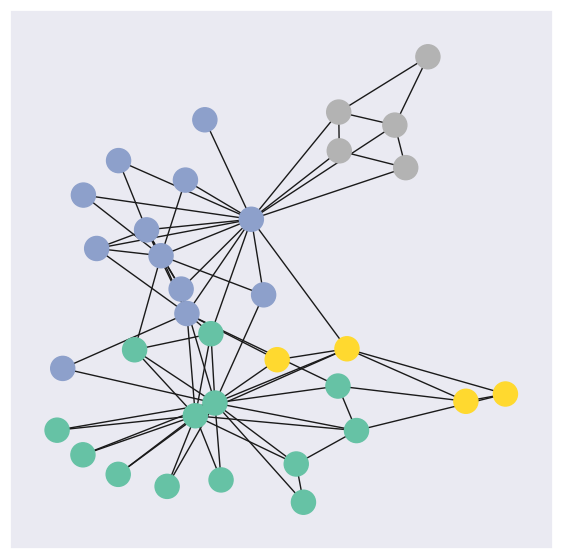

In [40]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

Another way to visualize graph is using `pyvis`. You may download (if on Google Colab) and open the generated `nx.html` file from your local browser.

In [41]:
for i in range(len(G.nodes)):
    G.nodes[i]['group']=int(data.y[i]) # assign the class label to the node. class label has to be int.
from pyvis.network import Network
vis= Network(notebook=True,cdn_resources='remote')
vis.barnes_hut(spring_length=25, spring_strength=0.5, damping=0.6)
vis.from_nx(G)
vis.show_buttons(filter_=["physics"])
vis.save_graph('nx.html')

If you run this file locally, you can directly call

In [42]:
#!open nx.html

## <span style="color:LightBlue">Implementing a Graph Neural Network</span>

For this notebook, we will use a simple GNN which is the [Graph Convolution Network](https://towardsdatascience.com/graph-convolutional-networks-introduction-to-gnns-24b3f60d6c95) (GCN) layer.

- GCN is a specific type of GNN that uses convolutional operations to propagate information between nodes in a graph.

- GCNs leverage a localized aggregation of neighboring node features to update the representations of the nodes.

- GCNs are based on the convolutional operation commonly used in image processing, adapted to the graph domain.

- The layers in a GCN typically apply a graph convolution operation followed by non-linear activation functions.

- GCNs have been successful in tasks such as node classification, where nodes are labeled based on their features and graph structure.

Our GNN is defined by stacking three graph convolution layers, which corresponds to aggregating 3-hop neighborhood information around each node (all nodes up to 3 "hops" away). In addition, the GCNConv layers reduce the node feature dimensionality to 2, i.e., `34→4→4→2`. Each GCNConv layer is enhanced by a `tanh` non-linearity. We then apply a linear layer which acts as a classifier to map the nodes to 1 out of the 4 possible classes.

In [43]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


## <span style="color:LightBlue">Training the model</span>

To train the network, we will use the <span style="color:Violet">CrossEntropyLoss</span> for the loss function and <span style="color:Violet">Adam</span> as the gradient optimizer

In [ ]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  #Initialize the CrossEntropyLoss function.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Initialize the Adam optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    print(f'Epoch: {epoch}, Loss: {loss}')


There is much more analysis that can be done with GNNs on the Karate Club dataseet. See [here](https://www.linkedin.com/pulse/community-detection-social-networks-case-study-zacharys-marin/) for examples. Our goal in this lecture was to use it an way to introduce the implementation and use of GNNs within the Pytorch framework.

We will now turn to examples using simulated open data from the CMS experiment at the LHC.  The algorithms' inputs are features of the reconstructed charged particles in a jet and the secondary vertices associated with them. Describing the jet shower as a combination of particle-to-particle and particle-to-vertex interactions, the model is trained to learn a jet representation on which the classification problem isoptimized.

We show below an example using a community model called "DeepSets" and then compare to an Interaction Model GNN.

---

# <span style="color:Orange">Deep Sets</span>

We will start by looking at Deep Sets networks using PyTorch. The architecture is based on the following paper: [DeepSets](https://papers.nips.cc/paper/2017/file/f22e4747da1aa27e363d86d40ff442fe-Paper.pdf)

In [ ]:
!pip install wget
import wget

!pip install -U PyYAML
!pip install uproot
!pip install awkward
!pip install mplhep

In [ ]:
import yaml

# WGET for colab
if not os.path.exists("./tmp_data/definitions_lorentz.yml"):
    url = "https://raw.githubusercontent.com/jmduarte/iaifi-summer-school/main/book/definitions_lorentz.yml"
#    definitionsFile = wget.download(url)
    definitionsFile = wget_data(url)

with open("./tmp_data/definitions_lorentz.yml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)

features   = definitions["features"]
spectators = definitions["spectators"]
labels     = definitions["labels"]

nfeatures   = definitions["nfeatures"]
nspectators = definitions["nspectators"]
nlabels     = definitions["nlabels"]
ntracks     = definitions["ntracks"]

## <span style="color:LightBlue">Data Loader</span>

Here we have to define the dataset loader.

In [ ]:
# If in colab
if not os.path.exists("GraphDataset.py"):
    urlDSD = "https://raw.githubusercontent.com/jmduarte/iaifi-summer-school/main/book/DeepSetsDataset.py"
    DSD = wget.download(urlDSD)
if not os.path.exists("utils.py"):
    urlUtils = "https://raw.githubusercontent.com/jmduarte/iaifi-summer-school/main/book/utils.py"
    utils = wget.download(urlUtils)

from DeepSetsDataset import DeepSetsDataset

# For colab
import os.path

if not os.path.exists("./tmp_data/ntuple_merged_90.root"):
    urlFILE = "http://opendata.cern.ch/eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_90.root"
#    dataFILE = wget.download(urlFILE)
    dataFILE = wget_data(urlFILE)
train_files = ["./tmp_data/ntuple_merged_90.root"]

train_generator = DeepSetsDataset(
    features,
    labels,
    spectators,
    start_event=0,
    stop_event=10000,
    npad=ntracks,
    file_names=train_files,
)
train_generator.process()

test_generator = DeepSetsDataset(
    features,
    labels,
    spectators,
    start_event=10001,
    stop_event=14001,
    npad=ntracks,
    file_names=train_files,
)
test_generator.process()

## <span style="color:LightBlue">Deep Sets Network</span>

Deep Sets models are designed to be explicitly permutation invariant. At their core they are composed of two networks, $\phi$ and $\rho$, such that the total network $f$ is given by

$$ \Large
\begin{align}
    f &= \rho\left(\Sigma_{\mathbf{x}_i\in\mathcal{X}} ~ \phi(\mathbf{x}_i)\right)
\end{align}
$$

where $\mathbf{x}_i$ are the features for the $i$-th element in the input sequence $\mathcal{X}$.

We will define a DeepSets model that will take as input up to 60 of the tracks (with 48 features) with zero-padding.

In [48]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import (
    Sequential as Seq,
    Linear as Lin,
    ReLU,
    BatchNorm1d,
    AvgPool1d,
    Sigmoid,
    Conv1d,
)
from torch_scatter import scatter_mean

# ntracks = 60
inputs = 6
hidden1 = 64
hidden2 = 32
hidden3 = 16
classify1 = 50
outputs = 2

class DeepSets(torch.nn.Module):
    def __init__(self):
        super(DeepSets, self).__init__()
        self.phi = Seq(
            Conv1d(inputs, hidden1, 1),
            BatchNorm1d(hidden1),
            ReLU(),
            Conv1d(hidden1, hidden2, 1),
            BatchNorm1d(hidden2),
            ReLU(),
            Conv1d(hidden2, hidden3, 1),
            BatchNorm1d(hidden3),
            ReLU(),
        )
        self.rho = Seq(
            Lin(hidden3, classify1),
            BatchNorm1d(classify1),
            ReLU(),
            Lin(classify1, outputs),
            Sigmoid(),
        )

    def forward(self, x):
        out = self.phi(x)
        out = scatter_mean(out, torch.LongTensor(np.zeros(ntracks)), dim=-1)
        return self.rho(torch.squeeze(out))


model = DeepSets()
print(model)
print("----------")
print({l: model.state_dict()[l].shape for l in model.state_dict()})

model = DeepSets().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

DeepSets(
  (phi): Sequential(
    (0): Conv1d(6, 64, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (rho): Sequential(
    (0): Linear(in_features=16, out_features=50, bias=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=2, bias=True)
    (4): Sigmoid()
  )
)
----------
{'phi.0.weight': torch.Size([64, 6, 1]), 'phi.0.bias': torch.Size([64]), 'phi.1.weight': torch.Size([64]), 'phi.1.bias': torch.Size([64]), 'phi.1.running_mean': torch.Size([64]), 'phi.1.running_var': torch

## <span style="color:LightBlue">Define the training loop</span>

In [49]:
@torch.no_grad()
def test(model, loader, total, batch_size, leave=False):
    model.eval()

    xentropy = nn.CrossEntropyLoss(reduction="mean")

    sum_loss = 0.0
    t = tqdm(enumerate(loader), total=total / batch_size, leave=leave)
    for i, data in t:
        x = data[0].to(device)
        y = data[1].to(device)
        y = torch.argmax(y, dim=1)
        batch_output = model(x)
        batch_loss_item = xentropy(batch_output, y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh()  # to show immediately the update

    return sum_loss / (i + 1)

def train(model, optimizer, loader, total, batch_size, leave=False):
    model.train()

    xentropy = nn.CrossEntropyLoss(reduction="mean")

    sum_loss = 0.0
    t = tqdm(enumerate(loader), total=total / batch_size, leave=leave)
    for i, data in t:
        x = data[0].to(device)
        y = data[1].to(device)
        y = torch.argmax(y, dim=1)
        optimizer.zero_grad()
        batch_output = model(x)
        batch_loss = xentropy(batch_output, y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh()  # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()

    return sum_loss / (i + 1)

## <span style="color:LightBlue">Define training, validation, testing data generators</span>

In [50]:
from torch.utils.data import ConcatDataset

train_generator_data = ConcatDataset(train_generator.datas)
test_generator_data = ConcatDataset(test_generator.datas)

In [51]:
from torch.utils.data import random_split, DataLoader

torch.manual_seed(0)
valid_frac = 0.20
train_length = len(train_generator_data)
valid_num = int(valid_frac * train_length)
batch_size = 32

train_dataset, valid_dataset = random_split(
    train_generator_data, [train_length - valid_num, valid_num]
)

def collate(items):
    l = sum(items, [])
    return Batch.from_data_list(l)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# train_loader.collate_fn = collate
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
# valid_loader.collate_fn = collate
test_loader = DataLoader(test_generator_data, batch_size=batch_size, shuffle=False)
# test_loader.collate_fn = collate

train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_generator_data)
print(train_length)
print(train_samples)
print(valid_samples)
print(test_samples)

9387
7510
1877
3751


## <span style="color:LightBlue">Train</span>

In [ ]:
import os.path as osp

n_epochs = 30
stale_epochs = 0
best_valid_loss = 99999
patience = 5
t = tqdm(range(0, n_epochs))

for epoch in t:
    loss = train(
        model,
        optimizer,
        train_loader,
        train_samples,
        batch_size,
        leave=bool(epoch == n_epochs - 1),
    )
    valid_loss = test(
        model,
        valid_loader,
        valid_samples,
        batch_size,
        leave=bool(epoch == n_epochs - 1),
    )
    print("Epoch: {:02d}, Training Loss:   {:.4f}".format(epoch, loss))
    print("           Validation Loss: {:.4f}".format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join("./tmp_data/deepsets_best.pth")
        print("New best model saved to:", modpath)
        torch.save(model.state_dict(), modpath)
        stale_epochs = 0
    else:
        print("Stale epoch")
        stale_epochs += 1
    if stale_epochs >= patience:
        print("Early stopping after %i stale epochs" % patience)
        break

## <span style="color:LightBlue">Evaluate on Test Data</span>

In [ ]:
# #In case you need to load the model from a pth file
# #Trained on 4 vectors (as above in notebook)
# urlPTH = "https://raw.githubusercontent.com/jmduarte/iaifi-summer-school/main/book/deepsets_best_4vec.pth"
# pthFile = wget.download(urlPTH)
# model.load_state_dict(torch.load("deepsets_best_4vec.pth"))
# #Trained on all possible inputs (a different configuration)
# urlPTH = "https://raw.githubusercontent.com/jmduarte/iaifi-summer-school/main/book/deepsets_best_AllTraining.pth"
# pthFile = wget.download(urlPTH)
# model.load_state_dict(torch.load("deepsets_best_AllTraining.pth"))

model.eval()
t = tqdm(enumerate(test_loader), total=test_samples / batch_size)
y_test_ds = []
y_predict_ds = []
track_pt = []
for i, data in t:
    x = data[0].to(device)
    y = data[1].to(device)
    track_pt.append(x[:, 0, 0].numpy())
    batch_output = model(x)
    y_predict_ds.append(batch_output.detach().cpu().numpy())
    y_test_ds.append(y.cpu().numpy())
track_pt = np.concatenate(track_pt)
y_test_ds = np.concatenate(y_test_ds)
y_predict_ds = np.concatenate(y_predict_ds)

[]

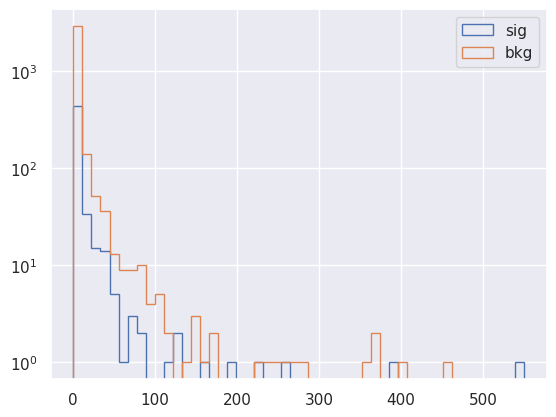

In [56]:
_, bins, _ = plt.hist(track_pt[y_test_ds[:, 1] == 1], bins=50, label="sig", histtype="step")
_, bins, _ = plt.hist(track_pt[y_test_ds[:, 1] == 0], bins=bins, label="bkg", histtype="step")
plt.legend()
plt.semilogy()

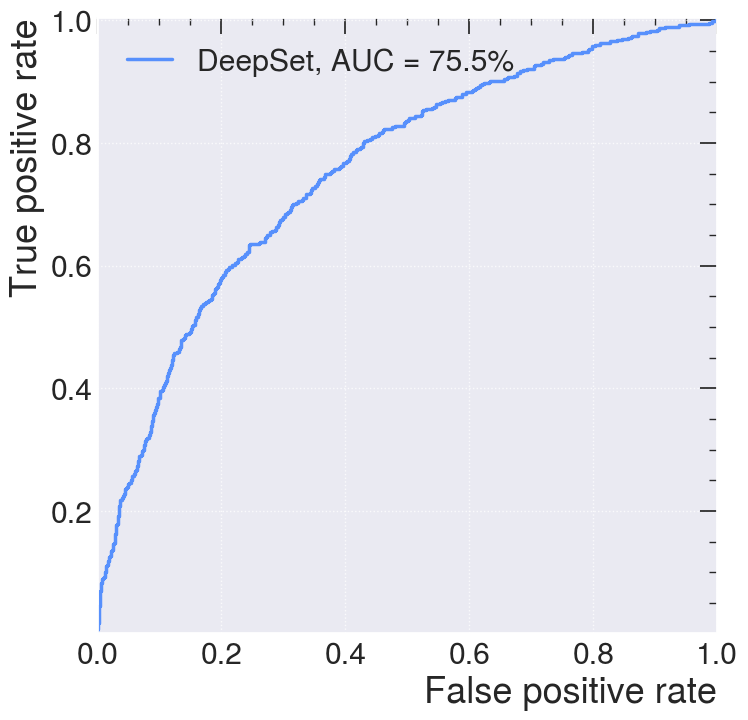

In [75]:
from sklearn.metrics import roc_curve, auc
import mplhep as hep

plt.style.use(hep.style.ROOT)
# create ROC curves
fpr_deepset, tpr_deepset, threshold_deepset = roc_curve(y_test_ds[:, 1], y_predict_ds[:, 1])
with open("./tmp_data/deepset_roc.npy", "wb") as f:
    np.save(f, fpr_deepset)
    np.save(f, tpr_deepset)
    np.save(f, threshold_deepset)

# plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(
    fpr_deepset,
    tpr_deepset,
    lw=2.5,
    label="DeepSet, AUC = {:.1f}%".format(auc(fpr_deepset, tpr_deepset) * 100),
)
plt.xlabel(r"False positive rate")
plt.ylabel(r"True positive rate")
plt.ylim(0.001, 1.005)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

### <span style="color:LightGreen">AUC and ROC Curves</span>

To better understand this curve, let define the <span style="color:Violet">confusion matrix</span>:

<div>
<img src="https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/img/GraphNeuralNetworks-ConfusionMatrix.png" width=400></img>
</div>

<span style="color:Violet">True Positive Rate</span> (TPR) is a synonym for recall/sensitivity and is therefore defined as follows:

$$ \Large
TPR = \frac{TP}{TP + FN}
$$

TPR tells us what proportion of the positive class got correctly classified. A simple example would be determining what proportion of the actual sick people were correctly detected by the model.

<span style="color:Violet">False Negative Rate</span> (FNR) is defined as follows:

$$ \Large
FNR = \frac{FN}{TP + FN}
$$

FNR tells us what proportion of the positive class got incorrectly classified by the classifier. A higher TPR and a lower FNR are desirable since we want to classify the positive class correctly.

<span style="color:Violet">True Negative Rate</span> (TNR) is a synonym for specificity and is defined as follows:

$$ \Large
TNR = \frac{TN}{TN + FP}
$$

Specificity tells us what proportion of the negative class got correctly classified. Taking the same example as in Sensitivity, Specificity would mean determining the proportion of healthy people who were correctly identified by the model.

<span style="color:Violet">False Positive Rate</span> (FPR) is defined as follows:

$$ \Large
TPR = \frac{FP}{TN + FP}
$$

FPR tells us what proportion of the negative class got incorrectly classified by the classifier. A higher TNR and a lower FPR are desirable since we want to classify the negative class correctly.

A <span style="color:Violet">ROC curve</span> (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

- True Positive Rate

- False Positive Rate

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

<div>
<img src="https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/img/GraphNeuralNetworks-ROC.png" width=400></img>
</div>

<span style="color:Violet">AUC</span> stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1). AUC provides an aggregate measure of performance across all possible classification thresholds.

<div>
<img src="https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/img/GraphNeuralNetworks-AUC.png" width=400></img>
</div>

# <span style="color:Orange">Interaction Network</span>

Now we will look at graph neural networks using the PyTorch Geometric library: <https://pytorch-geometric.readthedocs.io/>. See {cite:p}`PyTorchGeometric` for more details.

In [61]:
import yaml
import os.path

# WGET for colab
if not os.path.exists("./tmp_data/definitions.yml"):
    url = "https://raw.githubusercontent.com/jmduarte/iaifi-summer-school/main/book/definitions.yml"
    definitionsFile = wget.download(url)

with open("definitions.yml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)


# You can test with using only 4-vectors by using:
# if not os.path.exists("definitions_lorentz.yml"):
#    url = "https://raw.githubusercontent.com/jmduarte/iaifi-summer-school/main/book/definitions_lorentz.yml"
#    definitionsFile = wget.download(url)
# with open('definitions_lorentz.yml') as file:
#    # The FullLoader parameter handles the conversion from YAML
#    # scalar values to Python the dictionary format
#    definitions = yaml.load(file, Loader=yaml.FullLoader)

features = definitions["features"]
spectators = definitions["spectators"]
labels = definitions["labels"]

nfeatures = definitions["nfeatures"]
nspectators = definitions["nspectators"]
nlabels = definitions["nlabels"]
ntracks = definitions["ntracks"]

## <span style="color:LightBlue">Graph Datasets</span>

Here we have to define the graph dataset. We do this in a separate class following this example: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html#creating-larger-datasets

Formally, a graph is represented by a triplet $\mathcal G = (\mathbf{u}, V, E)$, consisting of a graph-level, or *global*, feature vector $\mathbf{u}$, a set of $N^v$ nodes $V$, and a set of $N^e$ edges $E$.
The nodes are given by $V = \{\mathbf{v}_i\}_{i=1:N^v}$, where $\mathbf{v}_i$ represents the $i$th node's attributes.
The edges connect pairs of nodes and are given by $E = \{\left(\mathbf{e}_k, r_k, s_k\right)\}_{k=1:N^e}$, where $\mathbf{e}_k$ represents the $k$th edge's attributes, and $r_k$ and $s_k$ are the indices of the "receiver" and
"sender" nodes, respectively, connected by the $k$th edge (from the sender node to the receiver node).
The receiver and sender index vectors are an alternative way of encoding the directed adjacency matrix.

<div>
<img src="https://github.com/jmduarte/capstone-particle-physics-domain/raw/master/weeks/attributes.png" alt="attributes" width="800">
</div>

In [ ]:
# If in colab
if not os.path.exists("GraphDataset.py"):
    urlDSD = "https://raw.githubusercontent.com/jmduarte/iaifi-summer-school/main/book/GraphDataset.py"
    DSD = wget.download(urlDSD)
if not os.path.exists("utils.py"):
    urlUtils = "https://raw.githubusercontent.com/jmduarte/iaifi-summer-school/main/book/utils.py"
    utils = wget.download(urlUtils)

from GraphDataset import GraphDataset

# For Colab
if not os.path.exists("./tmp_data/ntuple_merged_90.root"):
    urlFILE = "http://opendata.cern.ch/eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_90.root"
    dataFILE = wget.download(urlFILE)
file_names = ["./tmp_data/ntuple_merged_90.root"]

graph_dataset = GraphDataset(
    "./tmp_data/gdata_train",
    features,
    labels,
    spectators,
    start_event=0,
    stop_event=8000,
    n_events_merge=1,
    file_names=file_names,
)

test_dataset = GraphDataset(
    "./tmp_data/gdata_test",
    features,
    labels,
    spectators,
    start_event=8001,
    stop_event=10001,
    n_events_merge=1,
    file_names=file_names,
)

## <span style="color:LightBlue">Graph Neural Network</span>

Here, we recapitulate the "graph network" (GN) formalism described in this [paper](https://arxiv.org/abs/1612.00222), which generalizes various GNNs and other similar methods.

GNs are graph-to-graph mappings, whose output graphs have the same node and edge structure as the input. Formally, a GN block contains three "update" functions, $\phi$, and three "aggregation" functions, $\rho$. The stages of processing in a single GN block are:

$$
\begin{align}
    \mathbf{e}'_k &= \phi^e\left(\mathbf{e}_k, \mathbf{v}_{r_k}, \mathbf{v}_{s_k}, \mathbf{u} \right) & \mathbf{\bar{e}}'_i &= \rho^{e \rightarrow v}\left(E'_i\right) & \text{(Edge block),} \\
    \mathbf{v}'_i &= \phi^v\left(\mathbf{\bar{e}}'_i, \mathbf{v}_i, \mathbf{u}\right) &
    \mathbf{\bar{e}}' &= \rho^{e \rightarrow u}\left(E'\right) &  \text{(Node block),} \\
    \mathbf{u}' &= \phi^u\left(\mathbf{\bar{e}}', \mathbf{\bar{v}}', \mathbf{u}\right) &
    \mathbf{\bar{v}}' &= \rho^{v \rightarrow u}\left(V'\right) &\text{(Global block).}
\end{align}
$$

where $E'_i = \left\{\left(\mathbf{e}'_k, r_k, s_k \right)\right\}_{r_k=i,\; k=1:N^e}$ contains the updated edge features for edges whose receiver node is the $i^\text{th}$ node, $E' = \bigcup_i E_i' = \left\{\left(\mathbf{e}'_k, r_k, s_k \right)\right\}_{k=1:N^e}$ is the set of updated edges, and $V'=\left\{\mathbf{v}'_i\right\}_{i=1:N^v}$ is the set of updated nodes.

<div>
<img src="https://github.com/jmduarte/capstone-particle-physics-domain/raw/master/weeks/GN-full-block.png" alt="GN full block" width="800"></img>
</div>

We will define an interaction network model similar to this [paper](https://arxiv.org/abs/1909.12285), but just modeling the particle-particle interactions. It will take as input all of the tracks (with 48 features) without truncating or zero-padding. Another modification is the use of batch normalization {cite:p}`bn` layers to improve the stability of the training.

In [63]:
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv, global_mean_pool
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d
from torch_scatter import scatter_mean
from torch_geometric.nn import MetaLayer

inputs = 48
hidden = 128
outputs = 2

class EdgeBlock(torch.nn.Module):
    def __init__(self):
        super(EdgeBlock, self).__init__()
        self.edge_mlp = Seq(
            Lin(inputs * 2, hidden), BatchNorm1d(hidden), ReLU(), Lin(hidden, hidden)
        )

    def forward(self, src, dest, edge_attr, u, batch):
        out = torch.cat([src, dest], 1)
        return self.edge_mlp(out)


class NodeBlock(torch.nn.Module):
    def __init__(self):
        super(NodeBlock, self).__init__()
        self.node_mlp_1 = Seq(
            Lin(inputs + hidden, hidden),
            BatchNorm1d(hidden),
            ReLU(),
            Lin(hidden, hidden),
        )
        self.node_mlp_2 = Seq(
            Lin(inputs + hidden, hidden),
            BatchNorm1d(hidden),
            ReLU(),
            Lin(hidden, hidden),
        )

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1)
        return self.node_mlp_2(out)

class GlobalBlock(torch.nn.Module):
    def __init__(self):
        super(GlobalBlock, self).__init__()
        self.global_mlp = Seq(
            Lin(hidden, hidden), BatchNorm1d(hidden), ReLU(), Lin(hidden, outputs)
        )

    def forward(self, x, edge_index, edge_attr, u, batch):
        out = scatter_mean(x, batch, dim=0)
        return self.global_mlp(out)

class InteractionNetwork(torch.nn.Module):
    def __init__(self):
        super(InteractionNetwork, self).__init__()
        self.interactionnetwork = MetaLayer(EdgeBlock(), NodeBlock(), GlobalBlock())
        self.bn = BatchNorm1d(inputs)

    def forward(self, x, edge_index, batch):

        x = self.bn(x)
        x, edge_attr, u = self.interactionnetwork(x, edge_index, None, None, batch)
        return u


model = InteractionNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

## <span style="color:LightBlue">Define the training loop</span>

In [64]:
@torch.no_grad()
def test(model, loader, total, batch_size, leave=False):
    model.eval()

    xentropy = nn.CrossEntropyLoss(reduction="mean")

    sum_loss = 0.0
    t = tqdm(enumerate(loader), total=total / batch_size, leave=leave)
    for i, data in t:
        data = data.to(device)
        y = torch.argmax(data.y, dim=1)
        batch_output = model(data.x, data.edge_index, data.batch)
        batch_loss_item = xentropy(batch_output, y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh()  # to show immediately the update

    return sum_loss / (i + 1)

def train(model, optimizer, loader, total, batch_size, leave=False):
    model.train()

    xentropy = nn.CrossEntropyLoss(reduction="mean")

    sum_loss = 0.0
    t = tqdm(enumerate(loader), total=total / batch_size, leave=leave)
    for i, data in t:
        data = data.to(device)
        y = torch.argmax(data.y, dim=1)
        optimizer.zero_grad()
        batch_output = model(data.x, data.edge_index, data.batch)
        batch_loss = xentropy(batch_output, y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh()  # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()

    return sum_loss / (i + 1)

## <span style="color:LightBlue">Define training, validation, testing data generators</span>

In [65]:
from torch_geometric.data import Data, DataListLoader, Batch
from torch.utils.data import random_split


def collate(items):
    l = sum(items, [])
    return Batch.from_data_list(l)


torch.manual_seed(0)
valid_frac = 0.20
full_length = len(graph_dataset)
valid_num = int(valid_frac * full_length)
batch_size = 32

train_dataset, valid_dataset = random_split(
    graph_dataset, [full_length - valid_num, valid_num]
)

train_loader = DataListLoader(
    train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True
)
train_loader.collate_fn = collate
valid_loader = DataListLoader(
    valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False
)
valid_loader.collate_fn = collate
test_loader = DataListLoader(
    test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False
)
test_loader.collate_fn = collate


train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_dataset)
print(full_length)
print(train_samples)
print(valid_samples)
print(test_samples)

7501
6001
1500
1886


## <span style="color:LightBlue">Train</span>

In [ ]:
import os.path as osp

n_epochs = 10
stale_epochs = 0
best_valid_loss = 99999
patience = 5
t = tqdm(range(0, n_epochs))

for epoch in t:
    loss = train(
        model,
        optimizer,
        train_loader,
        train_samples,
        batch_size,
        leave=bool(epoch == n_epochs - 1),
    )
    valid_loss = test(
        model,
        valid_loader,
        valid_samples,
        batch_size,
        leave=bool(epoch == n_epochs - 1),
    )
    print("Epoch: {:02d}, Training Loss:   {:.4f}".format(epoch, loss))
    print("           Validation Loss: {:.4f}".format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join("./tmp_data/interactionnetwork_best.pth")
        print("New best model saved to:", modpath)
        torch.save(model.state_dict(), modpath)
        stale_epochs = 0
    else:
        print("Stale epoch")
        stale_epochs += 1
    if stale_epochs >= patience:
        print("Early stopping after %i stale epochs" % patience)
        break

## <span style="color:LightBlue">Evaluate on Test Data</span>

In [ ]:
# In case you need to load the model from a pth file
# Trained on all possible inputs (as above in notebook)
# urlPTH = "https://raw.githubusercontent.com/jmduarte/iaifi-summer-school/main/book/interactionnetwork_best_Aug1_AllTraining.pth"
# pthFile = wget.download(urlPTH)
# model.load_state_dict(torch.load("interactionnetwork_best_Aug1_AllTraining.pth"))
# Trained on 4 vector input (different setup)
# urlPTH = "https://raw.githubusercontent.com/jmduarte/iaifi-summer-school/main/book/interactionnetwork_best_Aug1_4vec.pth"
# pthFile = wget.download(urlPTH)
# model.load_state_dict(torch.load("interactionnetwork_best_Aug1_4vec.pth"))

model.eval()
t = tqdm(enumerate(test_loader), total=test_samples / batch_size)
y_test_gnn = []
y_predict_gnn = []
for i, data in t:
    data = data.to(device)
    batch_output = model(data.x, data.edge_index, data.batch)
    y_predict_gnn.append(batch_output.detach().cpu().numpy())
    y_test_gnn.append(data.y.cpu().numpy())
y_test_gnn = np.concatenate(y_test_gnn)
y_predict_gnn = np.concatenate(y_predict_gnn)

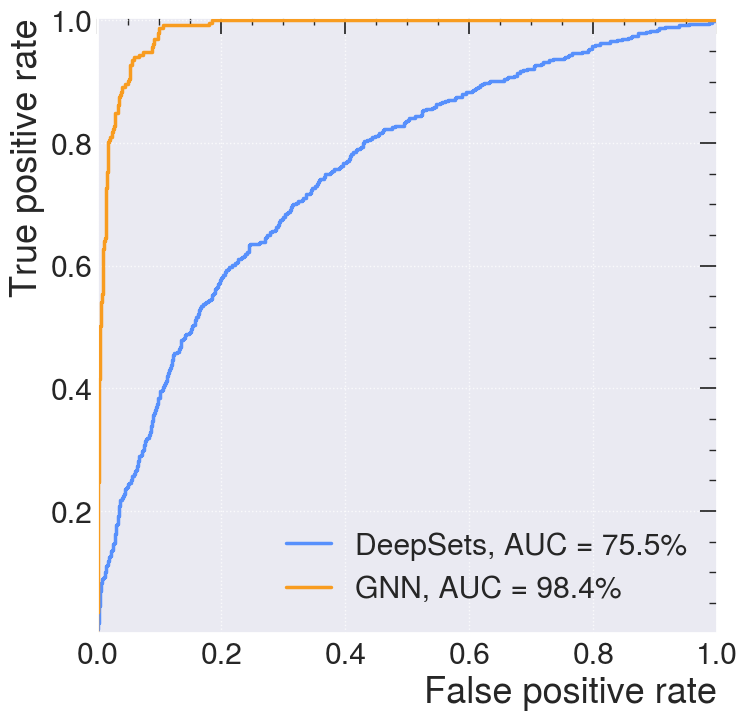

In [91]:
import numpy as np
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)

def to_labels(y):
    y = np.asarray(y)
    return y.argmax(axis=1).astype(int)

def to_scores(y_pred):
    p = np.asarray(y_pred)
    p_exp = np.exp(p - p.max(axis=1, keepdims=True))
    probs = p_exp / p_exp.sum(axis=1, keepdims=True)
    return probs[:, 1]  # score for positive class

# Compute scores for GNN
y_true_gnn  = to_labels(y_test_gnn)
y_score_gnn = to_scores(y_predict_gnn)

# ROC + AUC
fpr_gnn, tpr_gnn, thr_gnn = roc_curve(y_true_gnn, y_score_gnn)
auc_gnn = auc(fpr_gnn, tpr_gnn)

# Retrieve fromt previously calculated DeepSets AUC/ROC
with open("./tmp_data/deepset_roc.npy", "rb") as f:
    fpr_ds = np.load(f)
    tpr_ds = np.load(f)
    threshold_ds = np.load(f)
auc_ds = auc(fpr_ds, tpr_ds)

# Plot (x=FPR, y=TPR)
plt.figure(figsize=(8, 8))
plt.plot(fpr_ds, tpr_ds, lw=2.5, label=f"DeepSets, AUC = {auc_ds*100:.1f}%")
plt.plot(fpr_gnn, tpr_gnn, lw=2.5, label=f"GNN, AUC = {auc_gnn*100:.1f}%")

plt.xlabel(r"False positive rate")
plt.ylabel(r"True positive rate")
plt.ylim(0.001, 1.005)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

---
## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer
  * Materials from:
    * https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html
    * https://jduarte.physics.ucsd.edu/iaifi-summer-school/1.4_gnn_in.html

© Copyright 2025